In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("https://github.com/Thaniparn/MADT8101-Customer-Analytics/raw/3345f2ff0fc9b559c0edb3c004c50e34da4e6fad/Workshop4%20-%20Churn%20Scoring/Retail_Data_Transactions.csv")

In [11]:
df.tail()

,customer_id,trans_date,tran_amount
124995,CS8433,26-Jun-11,64
124996,CS7232,19-Aug-14,38
124997,CS8731,28-Nov-14,42
124998,CS8133,14-Dec-13,13
124999,CS7996,13-Dec-14,36


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [14]:
df.dropna(subset=['customer_id'], inplace=True)

In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tran_amount,125000.0,64.991912,22.860006,10.0,47.0,65.0,83.0,105.0


In [16]:
df['trans_date'] = pd.to_datetime(df['trans_date'])
df['trans_date'].min(), df['trans_date'].max()

(Timestamp('2011-05-16 00:00:00'), Timestamp('2015-03-16 00:00:00'))

In [17]:
df2 = df[['trans_date','customer_id']]
print(df2)

       trans_date customer_id
0      2013-02-11      CS5295
1      2015-03-15      CS4768
2      2013-02-26      CS2122
3      2011-11-16      CS1217
4      2013-11-20      CS1850
...           ...         ...
124995 2011-06-26      CS8433
124996 2014-08-19      CS7232
124997 2014-11-28      CS8731
124998 2013-12-14      CS8133
124999 2014-12-13      CS7996

[125000 rows x 2 columns]


<ipython-input-18-c9208bb3534a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['trans_date'] = pd.to_datetime(df2['trans_date'])


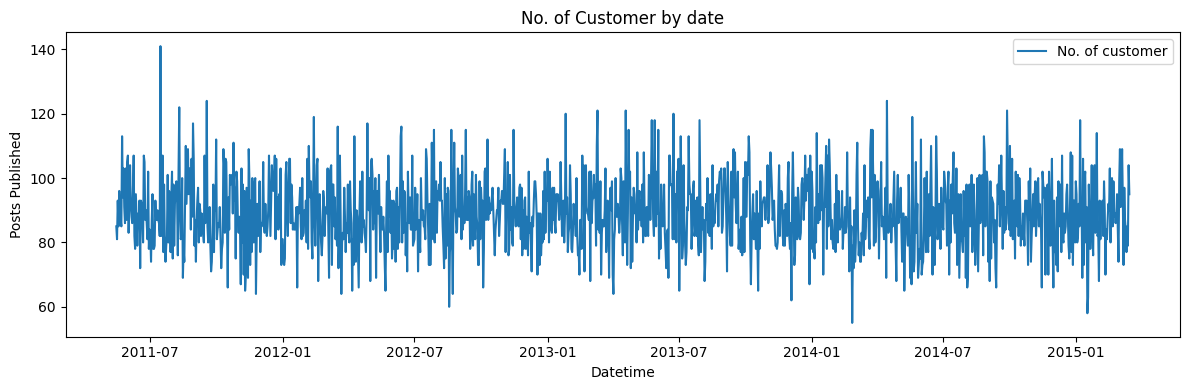

In [18]:
df2['trans_date'] = pd.to_datetime(df2['trans_date'])
df2.set_index('trans_date', inplace=True)

df2 = df2[['customer_id']].resample('D').count()
df2.replace(0, np.nan, inplace=True)

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(df2, label='No. of customer')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('No. of Customer by date')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:

n_orders = df.groupby(['customer_id'])['trans_date'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['customer_id'].nunique()
print(n_orders)
print(mult_orders_perc)
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

customer_id
CS1112    15
CS1113    19
CS1114    19
CS1115    22
CS1116    13
          ..
CS8996    13
CS8997    14
CS8998    13
CS8999    12
CS9000    13
Name: trans_date, Length: 6889, dtype: int64
1.0
100.00% of customers ordered more than once.


<ipython-input-20-b218c5d96cc8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(n_orders, kde=False, hist=True)


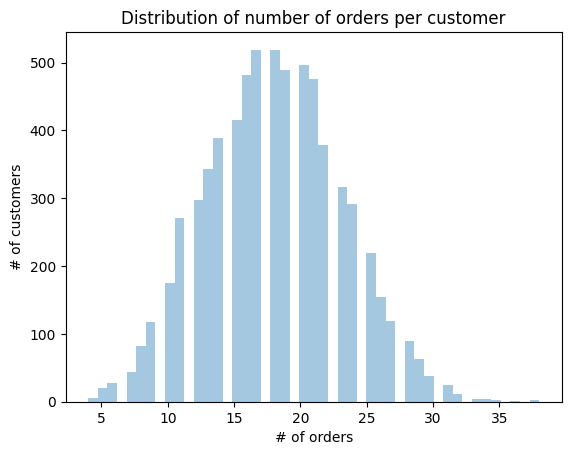

In [20]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders',
       ylabel='# of customers');

In [21]:
df = df[['customer_id','trans_date']].drop_duplicates()

In [22]:
df['trans_date'] = pd.to_datetime(df['trans_date'])
df['order_month'] = df['trans_date'].dt.to_period('M')
df['cohort'] = df.groupby('customer_id')['trans_date'] \
                 .transform('min') \
                 .dt.to_period('M')

In [23]:
df.head()

,customer_id,trans_date,order_month,cohort
0,CS5295,2013-02-11,2013-02,2011-10
1,CS4768,2015-03-15,2015-03,2011-05
2,CS2122,2013-02-26,2013-02,2011-10
3,CS1217,2011-11-16,2011-11,2011-05
4,CS1850,2013-11-20,2013-11,2011-08


In [24]:
print(df.loc[df['cohort']=='2013-10'])

       customer_id trans_date order_month   cohort
107785      CS8504 2014-10-10     2014-10  2013-10
108814      CS8504 2014-06-21     2014-06  2013-10
112379      CS8504 2013-10-26     2013-10  2013-10
119351      CS8504 2015-01-22     2015-01  2013-10


In [25]:
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [26]:
df_cohort.head()

,cohort,order_month,n_customers,period_number
0,2011-05,2011-05,1344,0
1,2011-05,2011-06,426,1
2,2011-05,2011-07,460,2
3,2011-05,2011-08,491,3
4,2011-05,2011-09,448,4


In [27]:
print(df_cohort.loc[df_cohort['cohort']=='2013-10'])

      cohort order_month  n_customers  period_number
768  2013-10     2013-10            1              0
769  2013-10     2014-06            1              8
770  2013-10     2014-10            1             12
771  2013-10     2015-01            1             15


In [28]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_pivot.head()

period_number,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
cohort,,,,,,,,,,,,,,,,,,,,,
2011-05,1344.0,426.0,460.0,491.0,448.0,489.0,403.0,458.0,457.0,445.0,...,457.0,477.0,441.0,438.0,465.0,433.0,425.0,460.0,411.0,262.0
2011-06,1804.0,580.0,612.0,580.0,607.0,563.0,586.0,607.0,567.0,632.0,...,592.0,623.0,561.0,579.0,586.0,606.0,577.0,520.0,325.0,NaN
2011-07,1215.0,416.0,413.0,425.0,387.0,424.0,390.0,387.0,397.0,391.0,...,403.0,391.0,397.0,406.0,381.0,433.0,374.0,208.0,NaN,NaN
2011-08,863.0,265.0,280.0,259.0,284.0,293.0,282.0,277.0,264.0,301.0,...,256.0,276.0,292.0,308.0,272.0,289.0,181.0,NaN,NaN,NaN
2011-09,467.0,133.0,139.0,169.0,168.0,142.0,150.0,150.0,144.0,129.0,...,171.0,150.0,147.0,144.0,133.0,97.0,NaN,NaN,NaN,NaN


In [29]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix.head()

period_number,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
cohort,,,,,,,,,,,,,,,,,,,,,
2011-05,1.0,0.316964,0.342262,0.365327,0.333333,0.363839,0.299851,0.340774,0.340030,0.331101,...,0.340030,0.354911,0.328125,0.325893,0.345982,0.322173,0.316220,0.342262,0.305804,0.19494
2011-06,1.0,0.321508,0.339246,0.321508,0.336475,0.312084,0.324834,0.336475,0.314302,0.350333,...,0.328160,0.345344,0.310976,0.320953,0.324834,0.335920,0.319845,0.288248,0.180155,NaN
2011-07,1.0,0.342387,0.339918,0.349794,0.318519,0.348971,0.320988,0.318519,0.326749,0.321811,...,0.331687,0.321811,0.326749,0.334156,0.313580,0.356379,0.307819,0.171193,NaN,NaN
2011-08,1.0,0.307068,0.324450,0.300116,0.329085,0.339513,0.326767,0.320973,0.305910,0.348783,...,0.296640,0.319815,0.338355,0.356895,0.315180,0.334878,0.209733,NaN,NaN,NaN
2011-09,1.0,0.284797,0.297645,0.361884,0.359743,0.304069,0.321199,0.321199,0.308351,0.276231,...,0.366167,0.321199,0.314775,0.308351,0.284797,0.207709,NaN,NaN,NaN,NaN


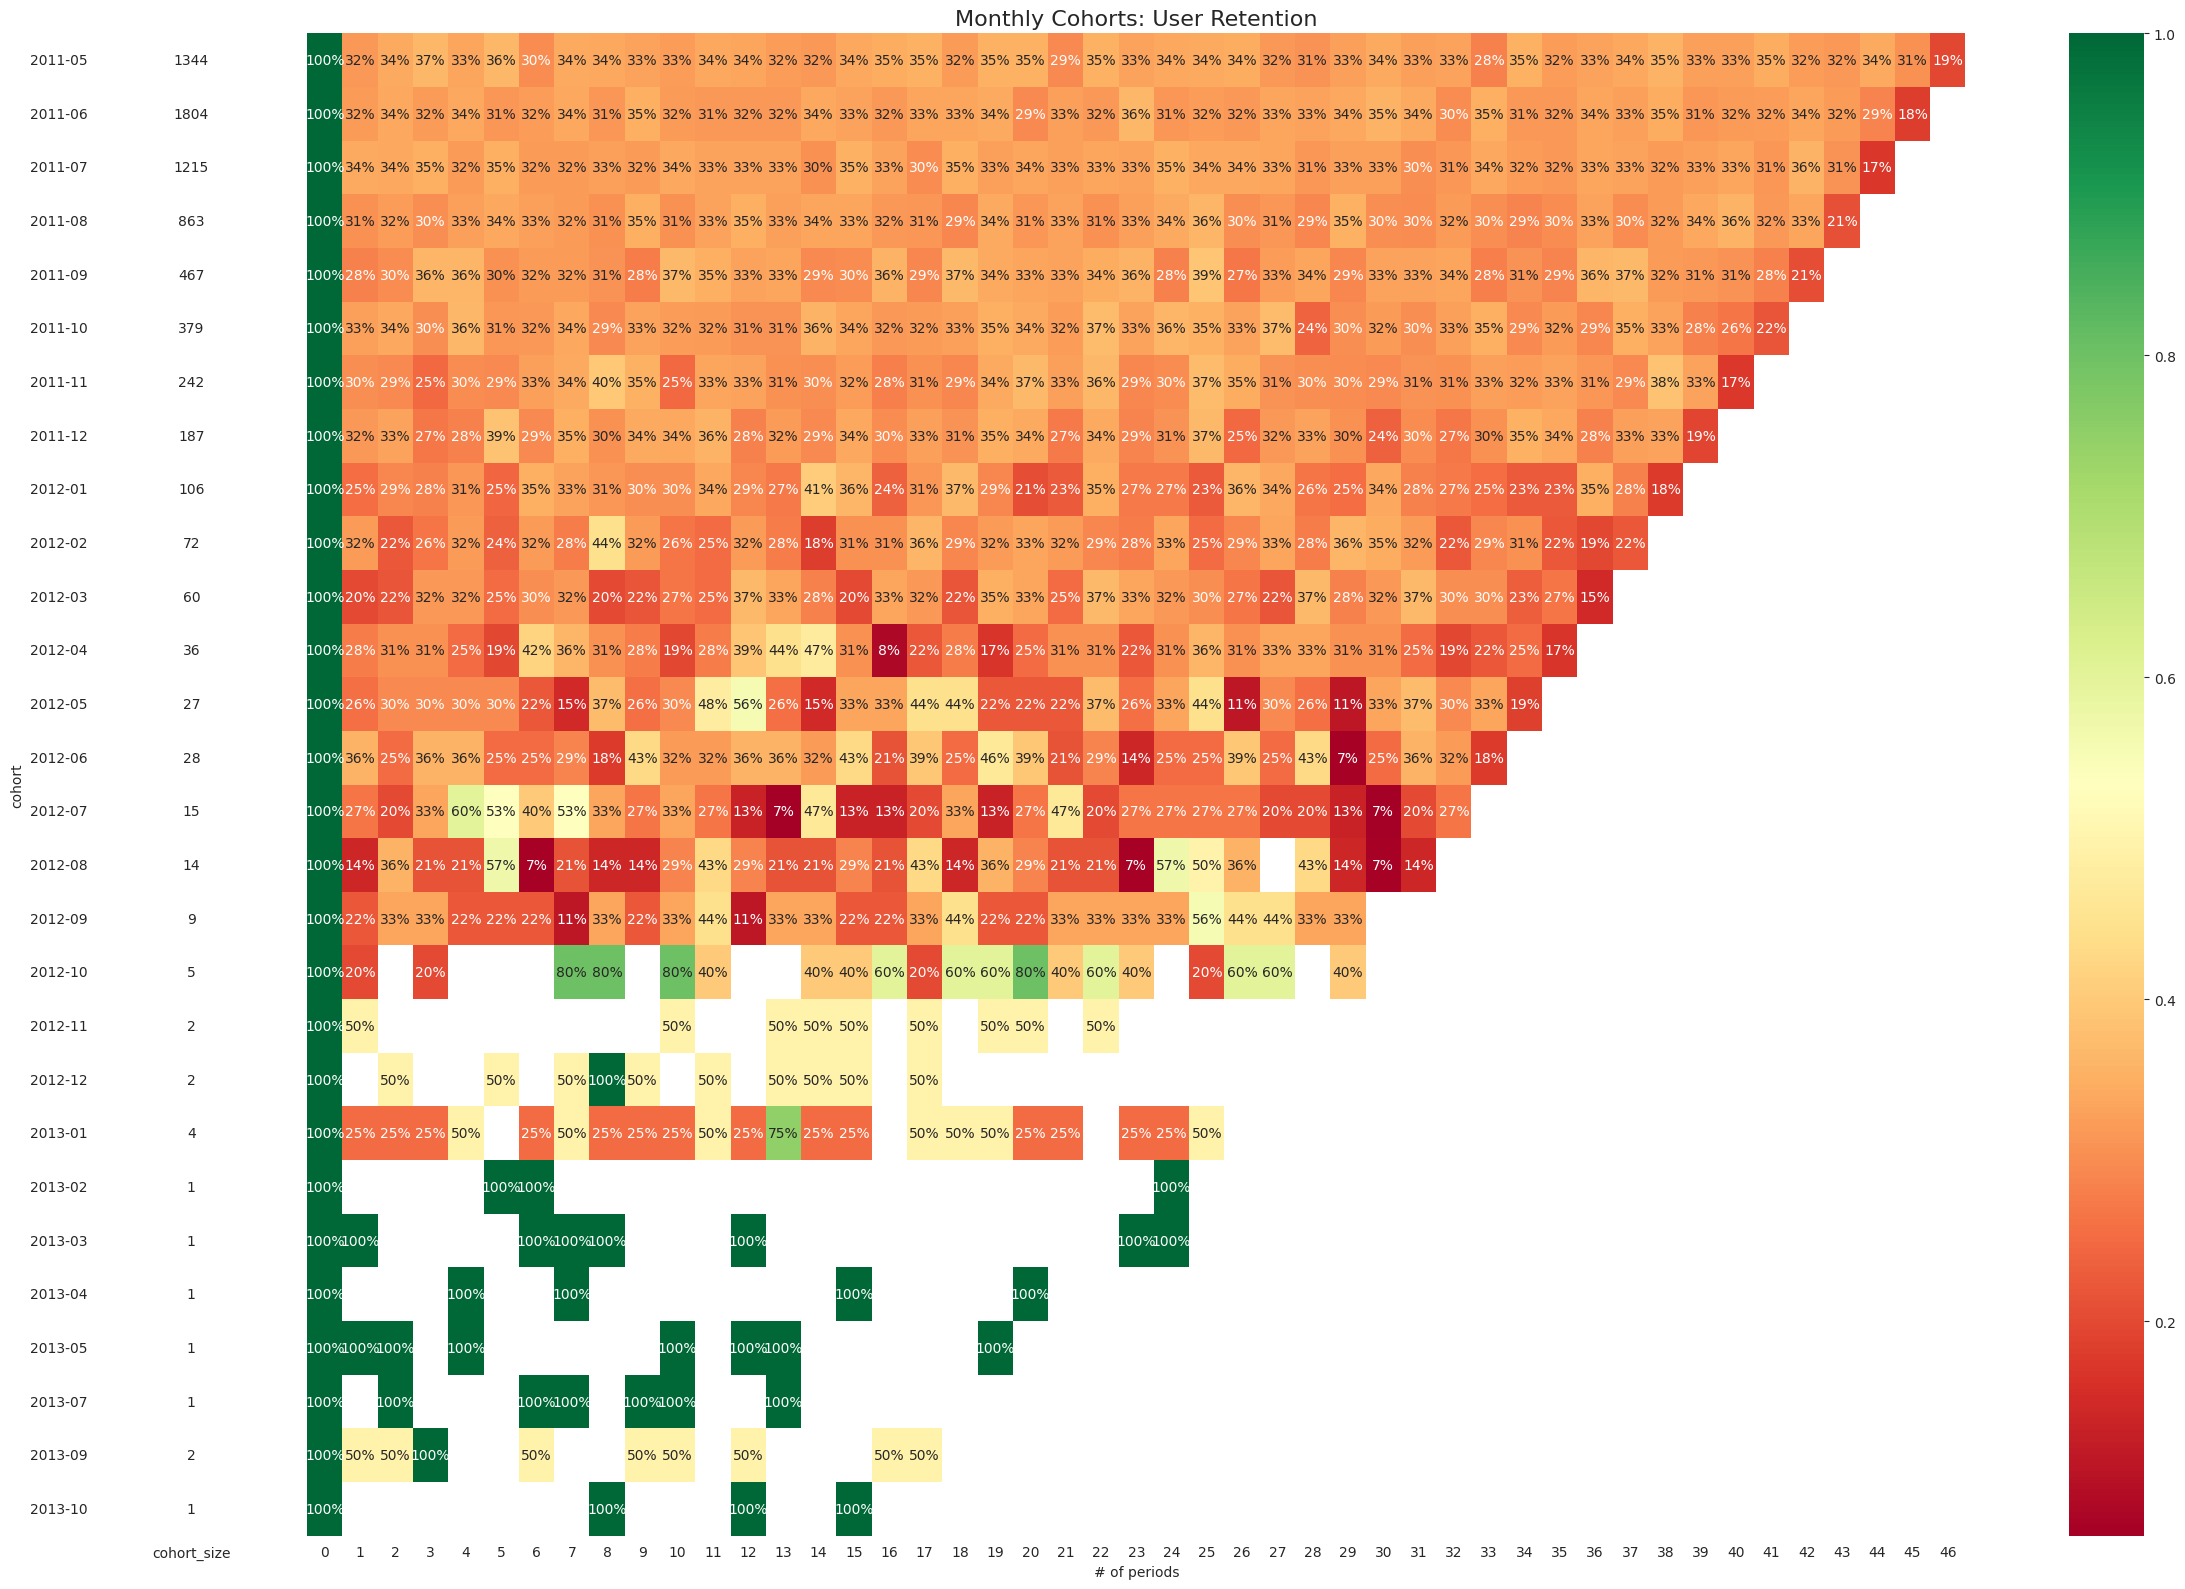

In [30]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(24, 16), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # retention matrix
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()

0        2014-11-25
1        2015-03-15
2        2015-02-23
3        2014-12-29
4        2015-03-09
            ...    
124995   2014-12-30
124996   2014-09-01
124997   2015-02-28
124998   2014-12-20
124999   2014-12-13
Name: trans_date, Length: 125000, dtype: datetime64[ns]


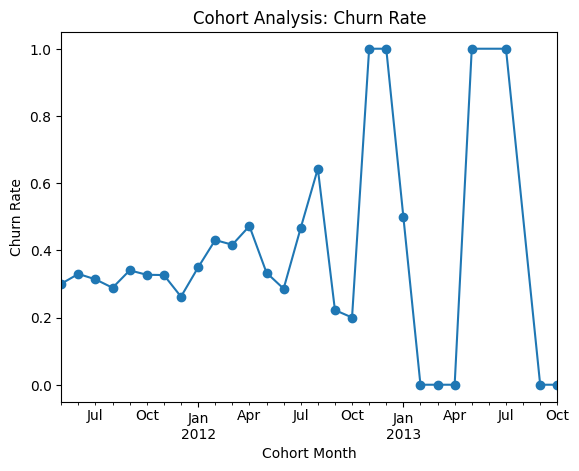

In [31]:
# Read the data frame containing customer_id, trans_date, and tran_amount
df = pd.read_csv("https://github.com/Thaniparn/MADT8101-Customer-Analytics/raw/3345f2ff0fc9b559c0edb3c004c50e34da4e6fad/Workshop4%20-%20Churn%20Scoring/Retail_Data_Transactions.csv")

# Preprocessing
df['trans_date'] = pd.to_datetime(df['trans_date'])  # Convert transaction date to datetime format

# Define cohorts based on the first transaction date within monthly periods
df['cohort_month'] = df.groupby('customer_id')['trans_date'].transform('min').dt.to_period('M')

# Calculate cohort metrics
df['cohort_total_amount'] = df.groupby(['cohort_month', 'customer_id'])['tran_amount'].transform('sum')
df['cohort_unique_customers'] = df.groupby(['cohort_month', 'customer_id'])['customer_id'].transform('nunique')

# Define churned customers
churn_period = pd.DateOffset(months=3)  # Example: churn defined as no transactions in the past 3 months
last_transaction_date = df.groupby('customer_id')['trans_date'].transform('max')
df['churned'] = (last_transaction_date < (df['trans_date'].max() - churn_period))
#print(churn_period)
print(last_transaction_date)

# Calculate churn rate
cohort_churn = df.groupby(['cohort_month', 'customer_id'])['churned'].max()
cohort_churn_rate = cohort_churn.groupby('cohort_month').mean()

# Visualize the churn rates
cohort_churn_rate.plot(kind='line', marker='o')
plt.xlabel('Cohort Month')
plt.ylabel('Churn Rate')
plt.title('Cohort Analysis: Churn Rate')
plt.show()

In [32]:
df.groupby('churned').count()

,customer_id,trans_date,tran_amount,cohort_month,cohort_total_amount,cohort_unique_customers
churned,,,,,,
False,88826,88826,88826,88826,88826,88826
True,36174,36174,36174,36174,36174,36174


In [33]:
# Read the data frame containing customer_id, trans_date, and tran_amount
df = pd.read_csv("https://github.com/Thaniparn/MADT8101-Customer-Analytics/raw/3345f2ff0fc9b559c0edb3c004c50e34da4e6fad/Workshop4%20-%20Churn%20Scoring/Retail_Data_Transactions.csv")

import pandas as pd
from datetime import timedelta
df['trans_date'] = pd.to_datetime(df['trans_date'])
df_sorted = df.sort_values(['customer_id', 'trans_date'])
df_sorted['transaction_lag'] = df_sorted.groupby('customer_id')['trans_date'].diff()
average_lag = df_sorted.groupby('customer_id')['transaction_lag'].mean()
all_average_lag = df_sorted['transaction_lag'].mean()

In [34]:
print(all_average_lag)

72 days 09:02:25.114341595


In [35]:
df['trans_date'] = pd.to_datetime(df['trans_date'])
#Create Test data set
reference_date = df['trans_date'].max()
cutoff_date = reference_date - pd.DateOffset(months=3)

high_value_customers = df[df['trans_date'] >= cutoff_date]

churners = high_value_customers.groupby('customer_id').filter(lambda x: x['trans_date'].max() <= reference_date + pd.DateOffset(months=4))
churners = churners['customer_id'].unique()

Test_churners = pd.DataFrame(churners, columns=['customer_id'])

print(Test_churners)



     customer_id
0         CS4768
1         CS5902
2         CS5552
3         CS2859
4         CS1512
...          ...
4690      CS8668
4691      CS8000
4692      CS8147
4693      CS8715
4694      CS8884

[4695 rows x 1 columns]


In [36]:
response = pd.read_csv("https://github.com/Thaniparn/MADT8101-Customer-Analytics/raw/3345f2ff0fc9b559c0edb3c004c50e34da4e6fad/Workshop4%20-%20Churn%20Scoring/Retail_Data_Response.csv")
print(response)

     customer_id  response
0         CS1112         0
1         CS1113         0
2         CS1114         1
3         CS1115         1
4         CS1116         1
...          ...       ...
6879      CS8996         0
6880      CS8997         0
6881      CS8998         0
6882      CS8999         0
6883      CS9000         0

[6884 rows x 2 columns]


In [37]:
TestSet = df[df['trans_date'] < cutoff_date]
TestData = pd.DataFrame()
TestData['customer_id'] = TestSet['customer_id'].unique()

TestSet['last_transaction_date'] = TestSet.groupby('customer_id')['trans_date'].transform('max')
TestSet['recency'] = (TestSet['last_transaction_date'].max() - TestSet['last_transaction_date']).dt.days
recency = TestSet[['customer_id', 'recency']].drop_duplicates()
TestData = TestData.merge(recency, on='customer_id')

TestSet['frequency'] = TestSet.groupby('customer_id')['trans_date'].transform('nunique')
frequency = TestSet[['customer_id', 'frequency']].drop_duplicates()
TestData = TestData.merge(frequency, on='customer_id')

TestSet['monetary_value'] = TestSet.groupby('customer_id')['tran_amount'].transform('sum')
monetary = TestSet[['customer_id', 'monetary_value']].drop_duplicates()
TestData = TestData.merge(monetary, on='customer_id')

TestData = TestData.merge(response, on='customer_id')

TestData['churned']= 0
TestData.loc[TestData['customer_id'].isin(Test_churners['customer_id']), 'churned'] = 1

print(TestData)

     customer_id  recency  frequency  monetary_value  response  churned
0         CS5295       20         25            1637         1        0
1         CS2122       35         22            1578         0        1
2         CS1217       21         19            1373         0        1
3         CS1850       33         19            1612         0        1
4         CS5539      121         17            1298         0        1
...          ...      ...        ...             ...       ...      ...
6879      CS8409      119          8             399         0        0
6880      CS8479       52          3             122         0        1
6881      CS7902      494          9             398         0        1
6882      CS7511      514          8             425         0        1
6883      CS8077       13          4             145         0        1

[6884 rows x 6 columns]


<ipython-input-37-12b91c53a98d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TestSet['last_transaction_date'] = TestSet.groupby('customer_id')['trans_date'].transform('max')
<ipython-input-37-12b91c53a98d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TestSet['recency'] = (TestSet['last_transaction_date'].max() - TestSet['last_transaction_date']).dt.days
<ipython-input-37-12b91c53a98d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [38]:
#Create Train data set
reference_date = df['trans_date'].max() - pd.DateOffset(months=3)
cutoff_date_train = reference_date - pd.DateOffset(months=3)

high_value_customers = df[(df['trans_date'] >= cutoff_date_train) & (df['trans_date'] <= reference_date)]

churners = high_value_customers.groupby('customer_id').filter(lambda x: x['trans_date'].max() <= reference_date + pd.DateOffset(months=3))
churners = churners['customer_id'].unique()

Train_churners = pd.DataFrame(churners, columns=['customer_id'])

print(Train_churners)

     customer_id
0         CS6087
1         CS2051
2         CS4704
3         CS5489
4         CS2703
...          ...
4742      CS8939
4743      CS8648
4744      CS8563
4745      CS7770
4746      CS7996

[4747 rows x 1 columns]


In [39]:
TrainSet = df[df['trans_date'] < cutoff_date_train]
TrainData = pd.DataFrame()
TrainData['customer_id'] = TrainSet['customer_id'].unique()

TrainSet['last_transaction_date'] = TrainSet.groupby('customer_id')['trans_date'].transform('max')
TrainSet['recency'] = (TrainSet['last_transaction_date'].max() - TrainSet['last_transaction_date']).dt.days
recency = TrainSet[['customer_id', 'recency']].drop_duplicates()
TrainData = TrainData.merge(recency, on='customer_id')

TrainSet['frequency'] = TrainSet.groupby('customer_id')['trans_date'].transform('nunique')
frequency = TrainSet[['customer_id', 'frequency']].drop_duplicates()
TrainData = TrainData.merge(frequency, on='customer_id')

TrainSet['monetary_value'] = TrainSet.groupby('customer_id')['tran_amount'].transform('sum')
monetary = TrainSet[['customer_id', 'monetary_value']].drop_duplicates()
TrainData = TrainData.merge(monetary, on='customer_id')

TrainData = TrainData.merge(response, on='customer_id')

TrainData['churned']= 0
TrainData.loc[TrainData['customer_id'].isin(Train_churners['customer_id']), 'churned'] = 1

print(TrainData)

     customer_id  recency  frequency  monetary_value  response  churned
0         CS5295      238         19            1177         1        1
1         CS2122       24         19            1409         0        1
2         CS1217       55         18            1320         0        1
3         CS1850       18         17            1415         0        1
4         CS5539       30         17            1298         0        0
...          ...      ...        ...             ...       ...      ...
6879      CS8409       28          8             399         0        0
6880      CS8479      900          2              83         0        1
6881      CS7902      403          9             398         0        0
6882      CS7511      423          8             425         0        0
6883      CS8077      610          3             118         0        1

[6884 rows x 6 columns]


<ipython-input-39-0588aa3d95f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TrainSet['last_transaction_date'] = TrainSet.groupby('customer_id')['trans_date'].transform('max')
<ipython-input-39-0588aa3d95f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TrainSet['recency'] = (TrainSet['last_transaction_date'].max() - TrainSet['last_transaction_date']).dt.days
<ipython-input-39-0588aa3d95f1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [40]:
## Explore Data
#Check completness, missing, outlier by k-mean or box plot, abnormal
#univariate analysis, bivariate analysis
#Char char Chai square, heat map
#Num num correlation, scatter pot
#Char num t-test, anova box plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind, f_oneway

class ExploreData:
    def __init__(self, df, yColumn):
        self.df = df
        self.yColumn = yColumn

    def CommonEvaluate(self):
      print('\nShow Head\n')
      print(self.df.head())
      print('\nShow Info\n')
      self.df.info()
      print('\nShow Tail\n')
      print(self.df.tail())
      print('\nSum n.a. record\n')
      print(self.df.isna().sum())
      print('\nDescribe number column\n')
      print(self.df.describe())

    def ColumnGraphEvaluate(self):
      print('============Evaluation by column============')
      for column in self.df.columns:
          print(f'\n{column}\n')
          if self.df[column].dtype == 'int64':  # Check if column has integer data type
            print(f'Box Plot for {column}')
            plt.figure()
            self.df.boxplot(column=column)
            plt.title(f'Box Plot - {column}')
            plt.show()
          elif self.df[column].dtype == 'object':  # Check if column has object data type
            # Display table
            print(f'\nTable - {column}:\n')
            print(self.df[column].value_counts())

            # Display bar chart
            plt.figure()
            self.df[column].value_counts().plot(kind='bar')
            plt.title(f'Bar Chart - {column}')
            plt.xlabel('Categories')
            plt.ylabel('Counts')
            plt.show()

    def EvaluateByTarget(self):
      print('============Evaluation by Target============')
      for column in self.df.columns:
        if column != self.yColumn:
            if self.df[column].dtype == 'object' and self.df[self.yColumn].dtype == 'object':  # Both feature and target are objects
                # Chi-square test
                contingency_table = pd.crosstab(self.df[column], self.df[self.yColumn])
                chi2, p_value, _, _ = chi2_contingency(contingency_table)

                print(f'{column} vs target:')
                print(f'Chi-square statistic: {chi2}')
                print(f'p-value: {p_value}\n')

                # Heatmap
                plt.figure()
                sns.heatmap(contingency_table, annot=True, fmt='d')
                plt.title(f'Heatmap - {column} vs target')
                plt.show()

            elif self.df[column].dtype == 'int64' and self.df[self.yColumn].dtype == 'int64':  # Both feature and target are integers
                # Correlation coefficient
                correlation = self.df[column].corr(self.df[self.yColumn])

                print(f'{column} vs target:')
                print(f'Correlation coefficient: {correlation}\n')

                # Scatter plot
                plt.figure()
                plt.scatter(self.df[column], self.df[self.yColumn])
                plt.title(f'Scatter Plot - {column} vs target')
                plt.xlabel(column)
                plt.ylabel('target')
                plt.show()
                sns.boxplot(data=self.df, x=self.df[self.yColumn], y=self.df[column])
                plt.show()

            else:  # Different data types
                groups = []
                for category in self.df[self.yColumn].unique():
                    # Exclude non-numeric values
                    group = self.df[self.df[self.yColumn] == category][column]
                    group = pd.to_numeric(group, errors='coerce')
                    group = group.dropna()
                    groups.append(group)

                if len(groups) > 1:
                    statistic, p_value = f_oneway(*groups) if len(groups) > 2 else ttest_ind(*groups)

                    print(f'{column} vs target:')
                    print(f'Statistic: {statistic}')
                    print(f'p-value: {p_value}\n')

                    # Box plot
                    #plt.figure()
                    #self.df.boxplot(column=column, by=self.yColumn)
                    #plt.title(f'Box Plot - {column} vs target')
                    #plt.xlabel('target')
                    #plt.ylabel(column)
                    #plt.show()

    def ProcessExploredata(self):
      self.CommonEvaluate()
      self.ColumnGraphEvaluate()
      self.EvaluateByTarget()



Show Head

   recency  frequency  response  monetary_value  churned
0      238         19         1            1177        1
1       24         19         0            1409        1
2       55         18         0            1320        1
3       18         17         0            1415        1
4       30         17         0            1298        0

Show Info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6884 entries, 0 to 6883
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   recency         6884 non-null   int64
 1   frequency       6884 non-null   int64
 2   response        6884 non-null   int64
 3   monetary_value  6884 non-null   int64
 4   churned         6884 non-null   int64
dtypes: int64(5)
memory usage: 322.7 KB

Show Tail

      recency  frequency  response  monetary_value  churned
6879       28          8         0             399        0
6880      900          2         0              83     

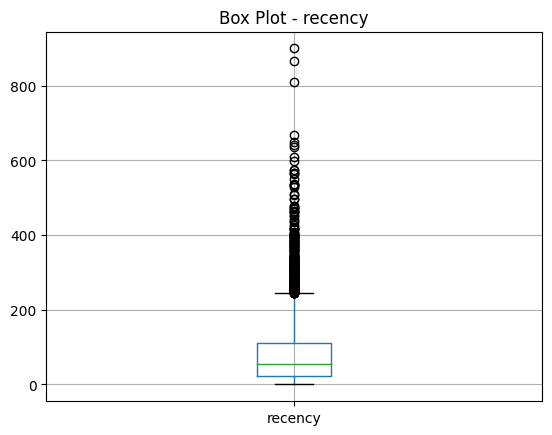


frequency

Box Plot for frequency


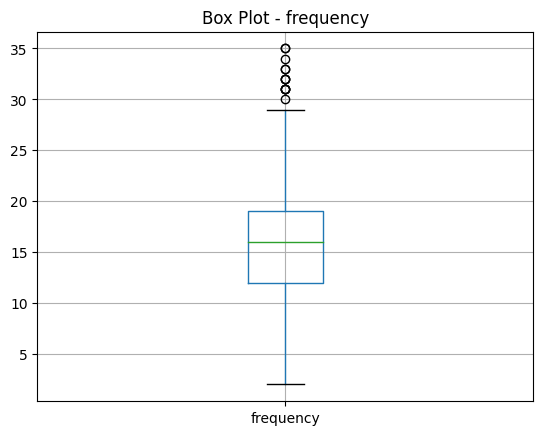


response

Box Plot for response


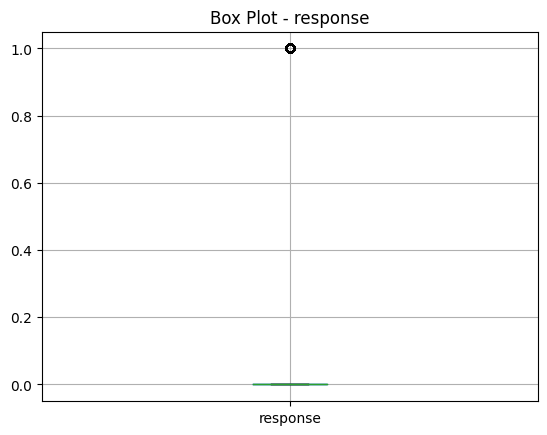


monetary_value

Box Plot for monetary_value


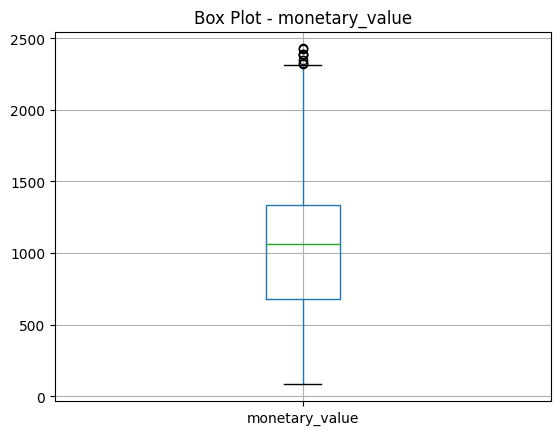


churned

Box Plot for churned


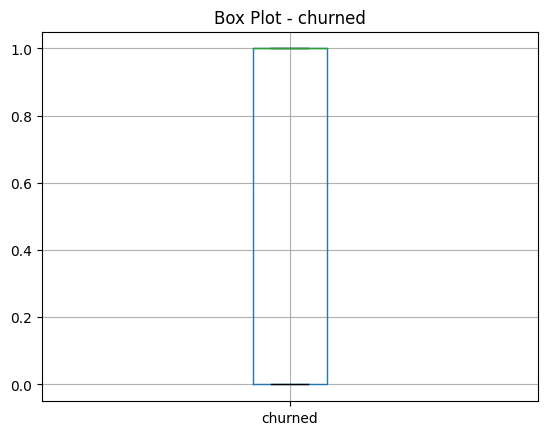

============Evaluation by Target============
recency vs target:
Correlation coefficient: -0.029457256889392953



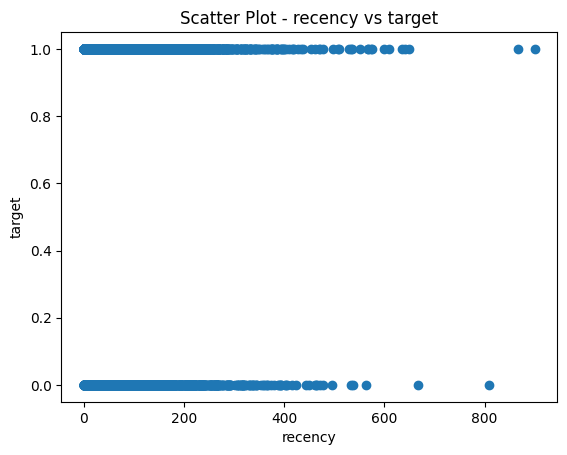

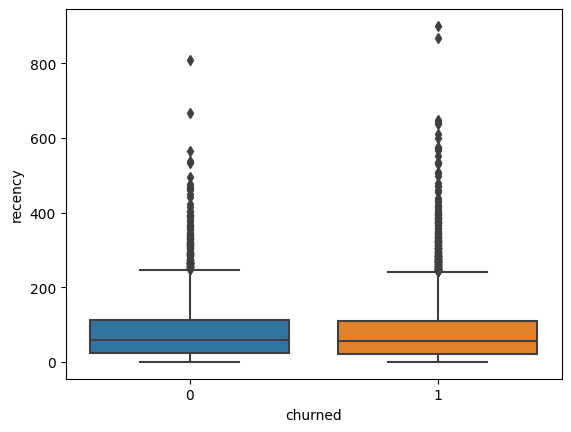

frequency vs target:
Correlation coefficient: 0.06924509640304156



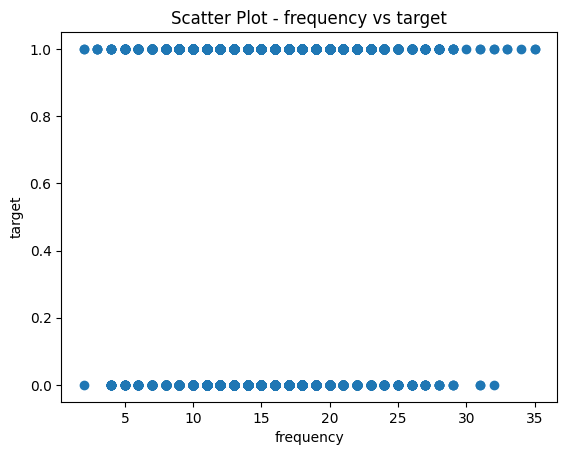

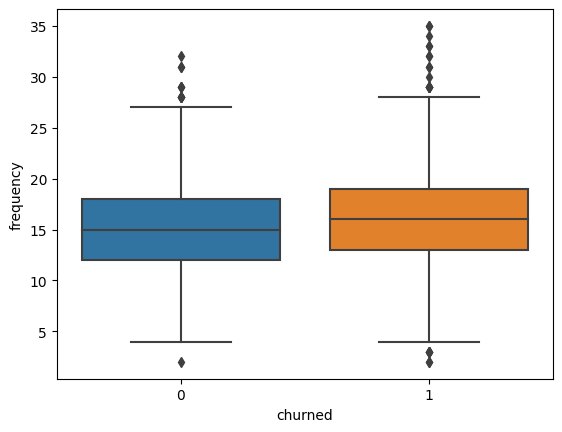

response vs target:
Correlation coefficient: 0.06331726489670458



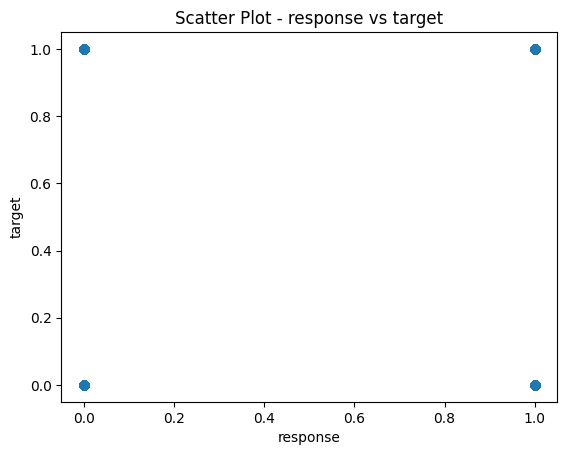

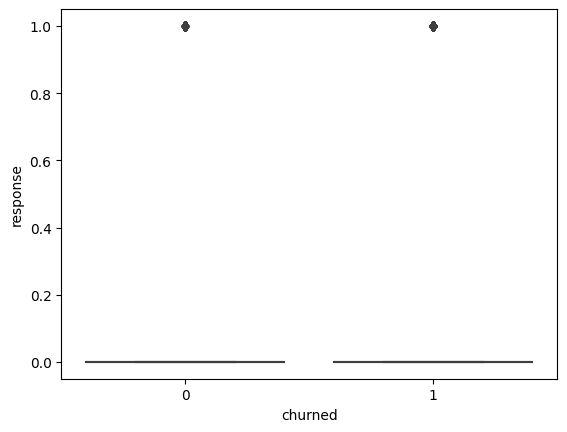

monetary_value vs target:
Correlation coefficient: 0.09995595009871988



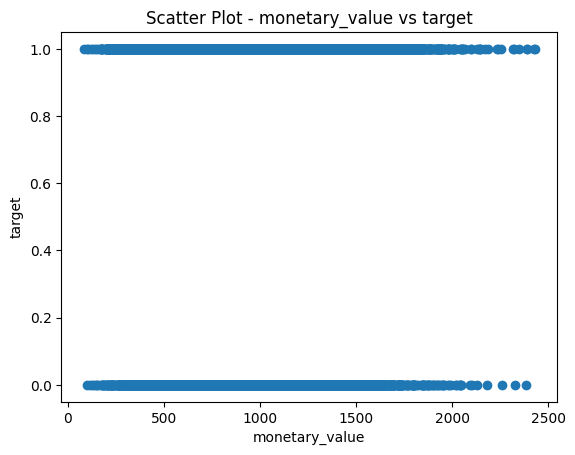

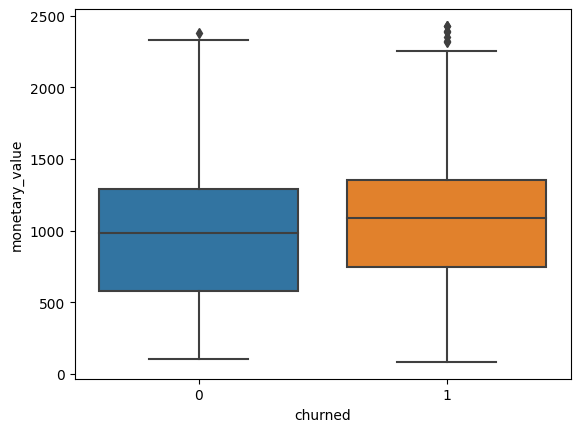

In [41]:
explore = ExploreData(TrainData[['recency','frequency','response','monetary_value','churned']],'churned')
explore.ProcessExploredata()

In [42]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc

In [43]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42,stratify=y)
X_train = TrainData[['recency','frequency','response','monetary_value']]
X_test = TestData[['recency','frequency','response','monetary_value']]
y_train = TrainData['churned']
y_test = TestData['churned']

In [44]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
class ModelEvaluatorNoon:
    def __init__(self, models,X_train, X_test, y_train, y_test):
        self.models = models
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    #Create Generic function to fit data and display results/predictions
    #clf = classifer
    def fit_evaluate_noon(self):
        results_noon = []

        for model_name, model in self.models.items():
          samplers = {'no_sampler':'none',
            'Under_Sampler': RandomUnderSampler(random_state=0),
            'Over_Sampler': RandomOverSampler(random_state=0),
            'SMOTE_Sampler': SMOTE(random_state=0),
          }


          for sampler_name, sampler in samplers.items():
            if sampler != 'none':
              sampler.fit(self.X_train, self.y_train)
              X_trainS, y_trainS = sampler.fit_resample(self.X_train, self.y_train)
            else:
              X_trainS = self.X_train
              y_trainS = self.y_train

            # fit model to training data
            model.fit(X_trainS, y_trainS)

            # make predictions for train data
            y_pred_train = model.predict(X_trainS)

            # make predictions for test data
            y_pred_test = model.predict(self.X_test)
            # print evaluation
            print(f'Model: {model_name}, Sampler: {sampler_name}')
            print(classification_report(self.y_test, y_pred_test))

            # Calculate F1 score
            f1 = f1_score(self.y_test, y_pred_test)
            precision = precision_score(self.y_test, y_pred_test)
            recall = recall_score(self.y_test, y_pred_test)

            results_noon.append({'Model': model_name, 'Sampler': sampler_name, 'Precision': precision, 'Recall': recall, 'F1 Score': f1})

            print('\nConfusion Matrix: \n')
            s = sns.heatmap(confusion_matrix(self.y_test, y_pred_test), annot=True, fmt='g', cmap='YlGnBu');
            s.set(xlabel='Predicted class', ylabel='True class')
            plt.show()

            try:
              with warnings.catch_warnings():

                fpr_train, tpr_train, _ = roc_curve(y_pred_train,  y_trainS)
                auc_train = roc_auc_score(y_pred_train, y_trainS)
                plt.plot(fpr_train,tpr_train, color='Blue', label='train: auc='+f'{auc_train:.2f}')
                fpr_test, tpr_test, _ = roc_curve(y_pred_test,  self.y_test)
                auc_test = roc_auc_score(y_pred_test, self.y_test)
                plt.plot(fpr_test,tpr_test, color='Red', label='test: auc='+f'{auc_test:.2f}')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.legend(loc=4)
                plt.show()
            except ValueError as e:
              print(f'Error calculating ROC AUC: {str(e)}')
        return pd.DataFrame(results_noon)

Model: Logistic Regression, Sampler: no_sampler
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2189
           1       0.68      1.00      0.81      4695

    accuracy                           0.68      6884
   macro avg       0.34      0.50      0.41      6884
weighted avg       0.47      0.68      0.55      6884


Confusion Matrix: 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


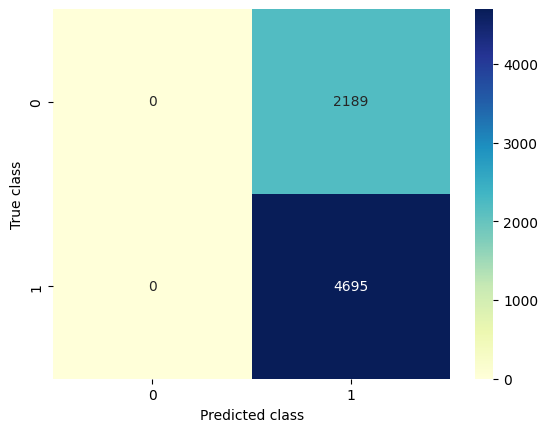

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Error calculating ROC AUC: Only one class present in y_true. ROC AUC score is not defined in that case.
Model: Logistic Regression, Sampler: Under_Sampler
              precision    recall  f1-score   support

           0       0.38      0.45      0.41      2189
           1       0.72      0.66      0.69      4695

    accuracy                           0.59      6884
   macro avg       0.55      0.55      0.55      6884
weighted avg       0.61      0.59      0.60      6884


Confusion Matrix: 



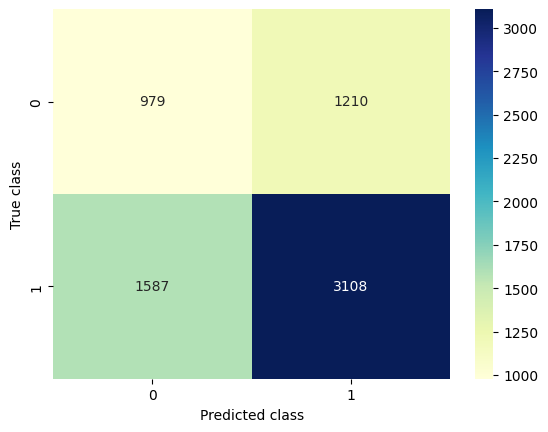

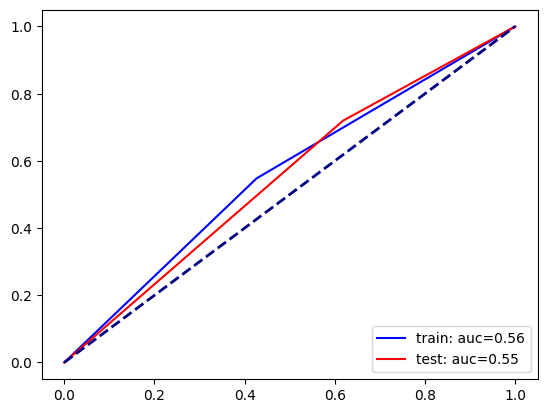

Model: Logistic Regression, Sampler: Over_Sampler
              precision    recall  f1-score   support

           0       0.37      0.47      0.41      2189
           1       0.72      0.63      0.67      4695

    accuracy                           0.58      6884
   macro avg       0.55      0.55      0.54      6884
weighted avg       0.61      0.58      0.59      6884


Confusion Matrix: 



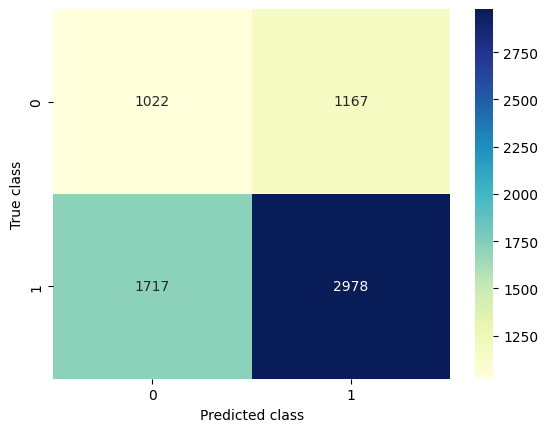

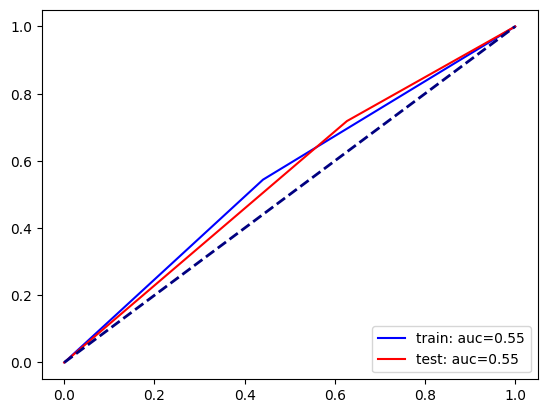

Model: Logistic Regression, Sampler: SMOTE_Sampler
              precision    recall  f1-score   support

           0       0.35      0.56      0.43      2189
           1       0.71      0.51      0.59      4695

    accuracy                           0.52      6884
   macro avg       0.53      0.53      0.51      6884
weighted avg       0.59      0.52      0.54      6884


Confusion Matrix: 



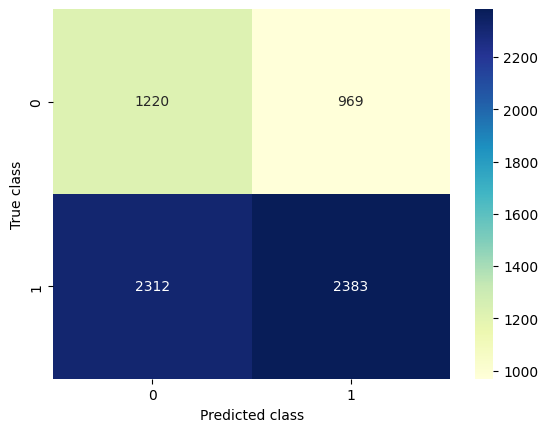

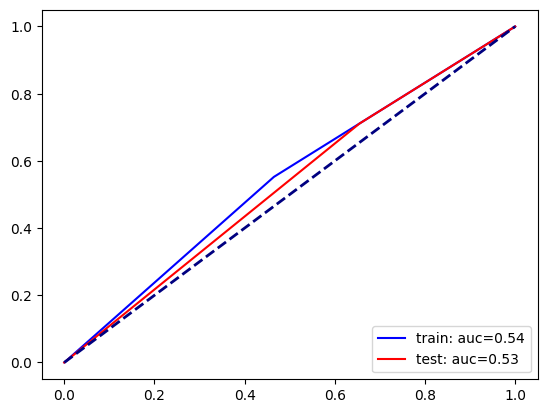

Model: Random Forest, Sampler: no_sampler
              precision    recall  f1-score   support

           0       0.38      0.24      0.29      2189
           1       0.70      0.81      0.75      4695

    accuracy                           0.63      6884
   macro avg       0.54      0.53      0.52      6884
weighted avg       0.59      0.63      0.61      6884


Confusion Matrix: 



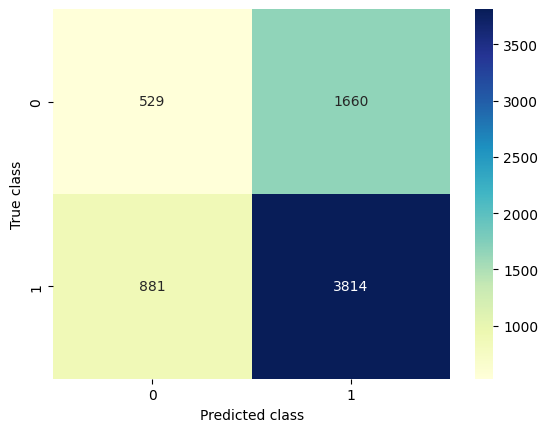

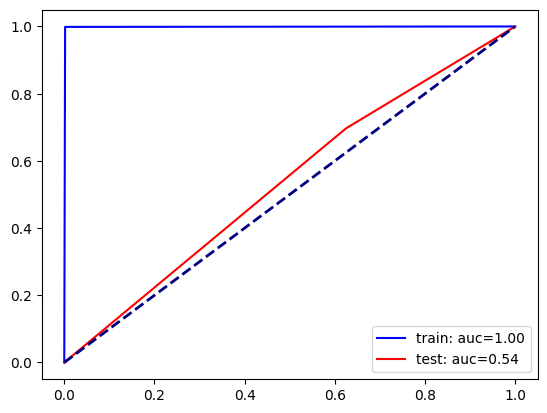

Model: Random Forest, Sampler: Under_Sampler
              precision    recall  f1-score   support

           0       0.33      0.55      0.41      2189
           1       0.70      0.49      0.58      4695

    accuracy                           0.51      6884
   macro avg       0.52      0.52      0.50      6884
weighted avg       0.58      0.51      0.52      6884


Confusion Matrix: 



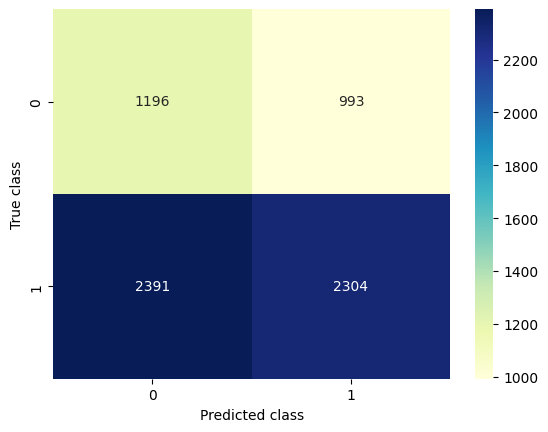

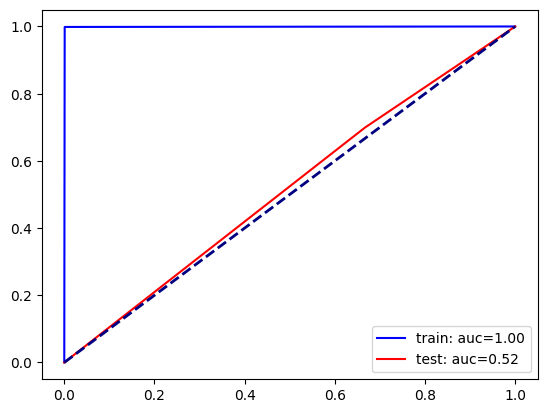

Model: Random Forest, Sampler: Over_Sampler
              precision    recall  f1-score   support

           0       0.35      0.32      0.33      2189
           1       0.69      0.72      0.71      4695

    accuracy                           0.59      6884
   macro avg       0.52      0.52      0.52      6884
weighted avg       0.58      0.59      0.59      6884


Confusion Matrix: 



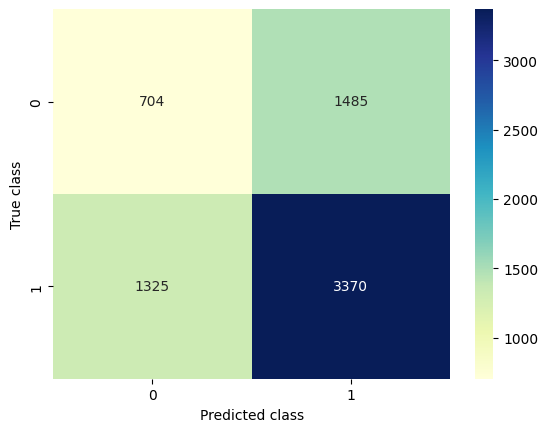

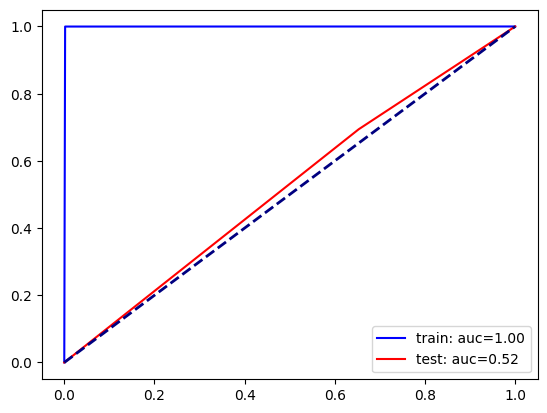

Model: Random Forest, Sampler: SMOTE_Sampler
              precision    recall  f1-score   support

           0       0.34      0.41      0.37      2189
           1       0.70      0.64      0.67      4695

    accuracy                           0.56      6884
   macro avg       0.52      0.52      0.52      6884
weighted avg       0.59      0.56      0.57      6884


Confusion Matrix: 



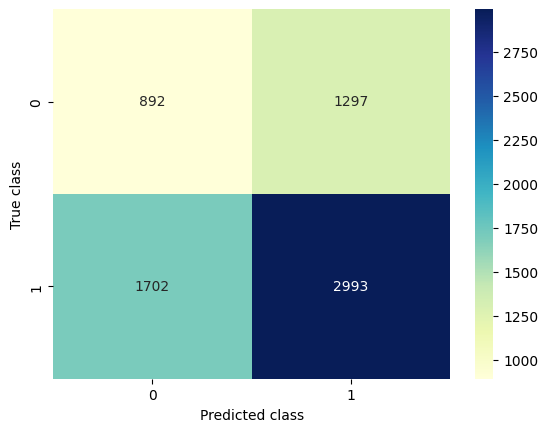

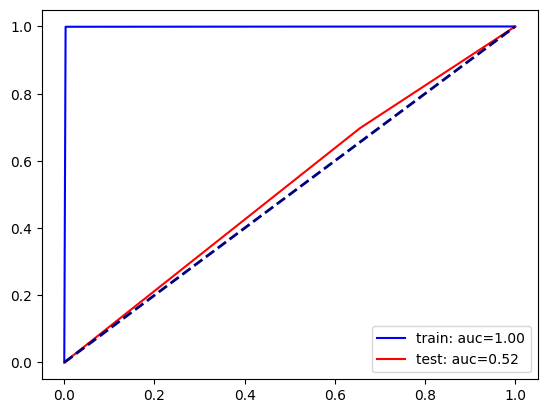

Model: KNeighbors, Sampler: no_sampler
              precision    recall  f1-score   support

           0       0.35      0.20      0.25      2189
           1       0.69      0.83      0.75      4695

    accuracy                           0.63      6884
   macro avg       0.52      0.51      0.50      6884
weighted avg       0.58      0.63      0.59      6884


Confusion Matrix: 



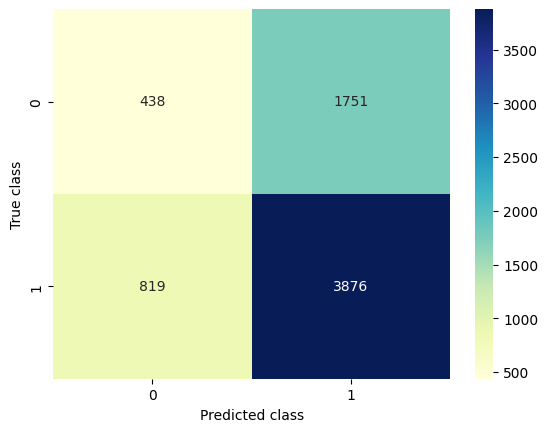

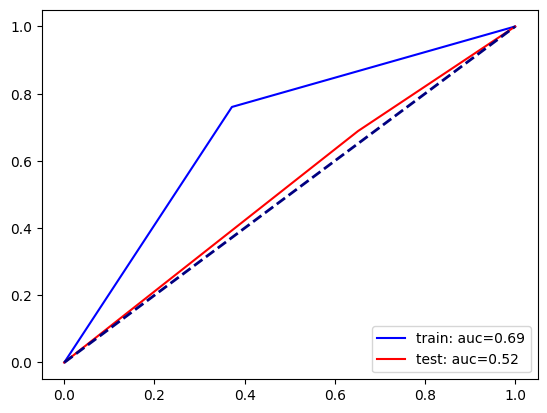

Model: KNeighbors, Sampler: Under_Sampler
              precision    recall  f1-score   support

           0       0.34      0.52      0.41      2189
           1       0.70      0.53      0.60      4695

    accuracy                           0.53      6884
   macro avg       0.52      0.53      0.51      6884
weighted avg       0.59      0.53      0.54      6884


Confusion Matrix: 



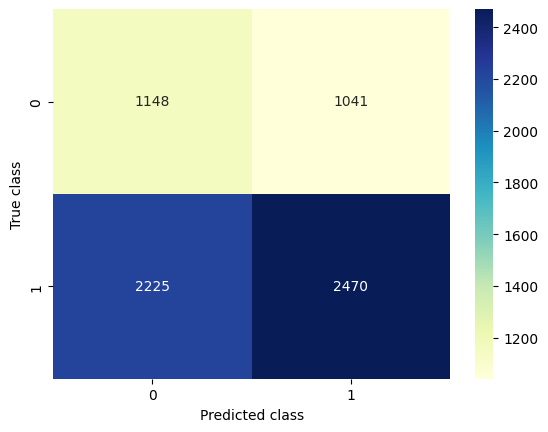

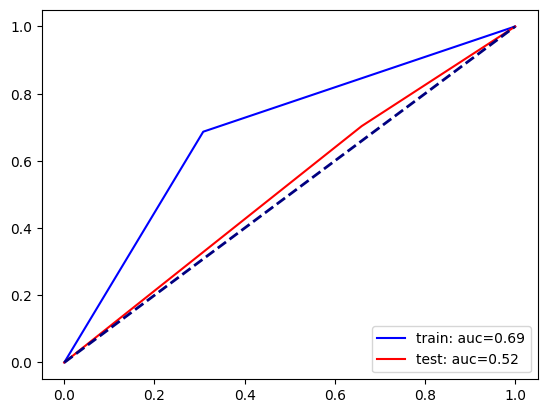

Model: KNeighbors, Sampler: Over_Sampler
              precision    recall  f1-score   support

           0       0.33      0.45      0.38      2189
           1       0.69      0.57      0.62      4695

    accuracy                           0.53      6884
   macro avg       0.51      0.51      0.50      6884
weighted avg       0.57      0.53      0.55      6884


Confusion Matrix: 



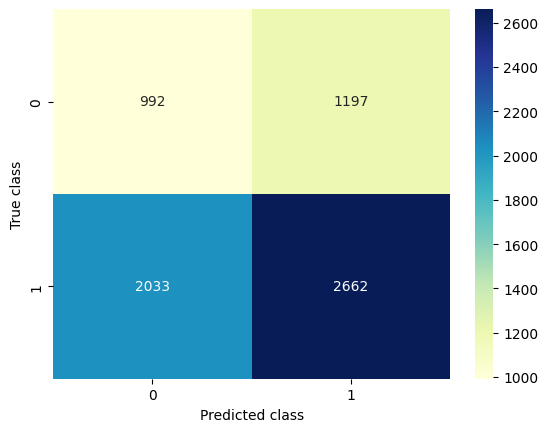

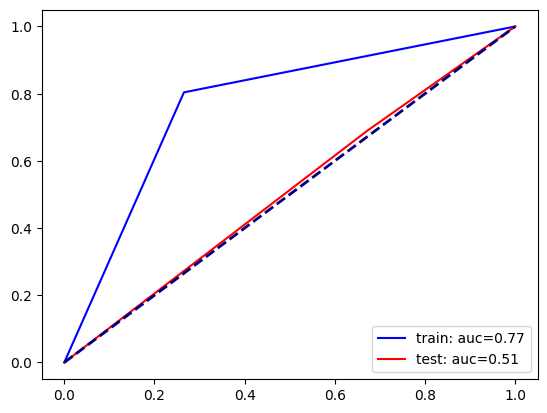

Model: KNeighbors, Sampler: SMOTE_Sampler
              precision    recall  f1-score   support

           0       0.32      0.44      0.37      2189
           1       0.69      0.56      0.62      4695

    accuracy                           0.53      6884
   macro avg       0.50      0.50      0.50      6884
weighted avg       0.57      0.53      0.54      6884


Confusion Matrix: 



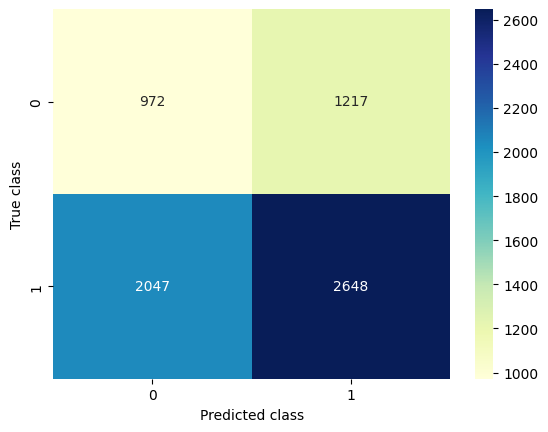

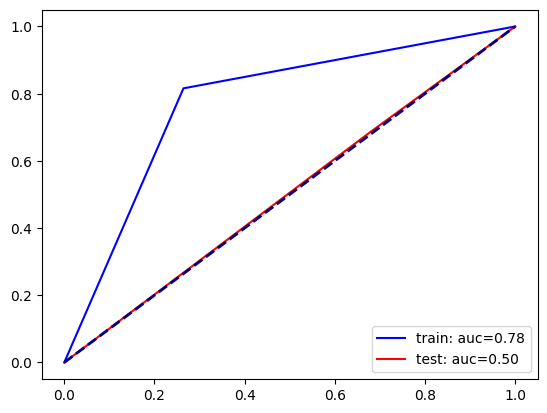

Model: XGBoost, Sampler: no_sampler
              precision    recall  f1-score   support

           0       0.37      0.14      0.21      2189
           1       0.69      0.88      0.77      4695

    accuracy                           0.65      6884
   macro avg       0.53      0.51      0.49      6884
weighted avg       0.59      0.65      0.59      6884


Confusion Matrix: 



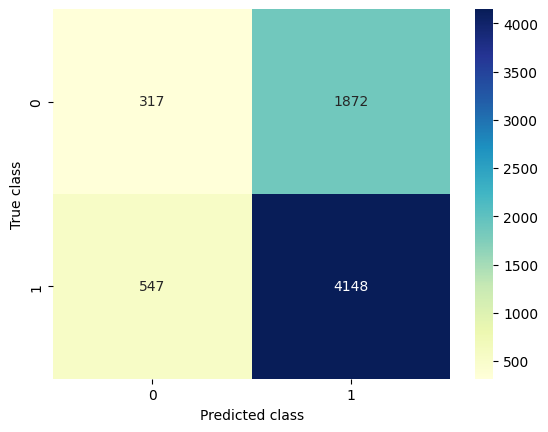

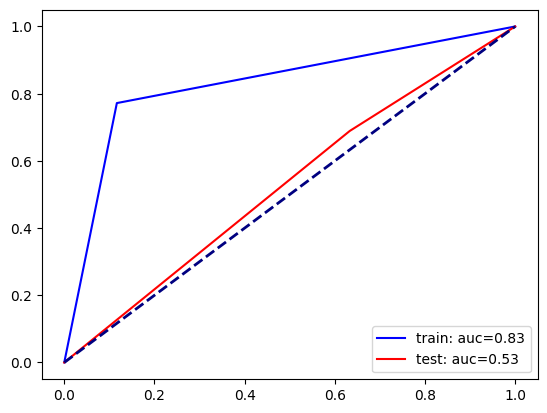

Model: XGBoost, Sampler: Under_Sampler
              precision    recall  f1-score   support

           0       0.34      0.55      0.42      2189
           1       0.71      0.50      0.59      4695

    accuracy                           0.52      6884
   macro avg       0.52      0.53      0.50      6884
weighted avg       0.59      0.52      0.53      6884


Confusion Matrix: 



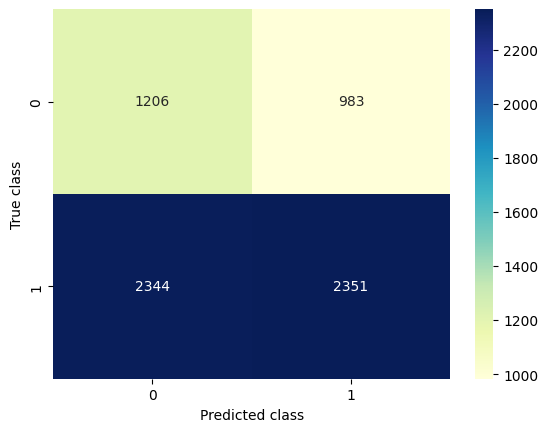

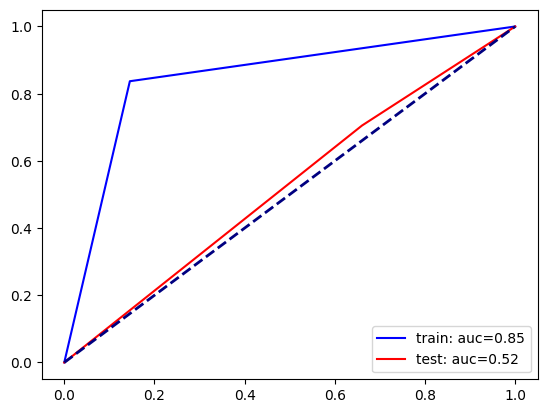

Model: XGBoost, Sampler: Over_Sampler
              precision    recall  f1-score   support

           0       0.34      0.41      0.37      2189
           1       0.70      0.63      0.66      4695

    accuracy                           0.56      6884
   macro avg       0.52      0.52      0.52      6884
weighted avg       0.58      0.56      0.57      6884


Confusion Matrix: 



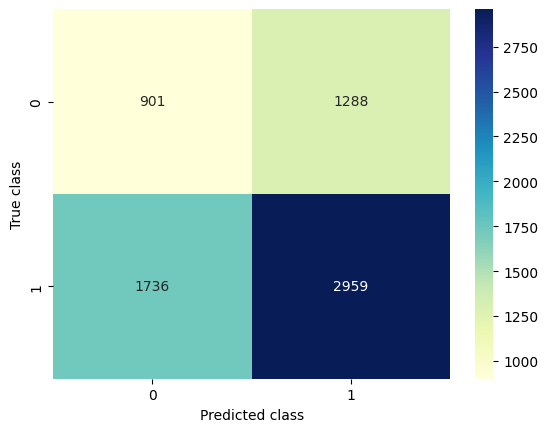

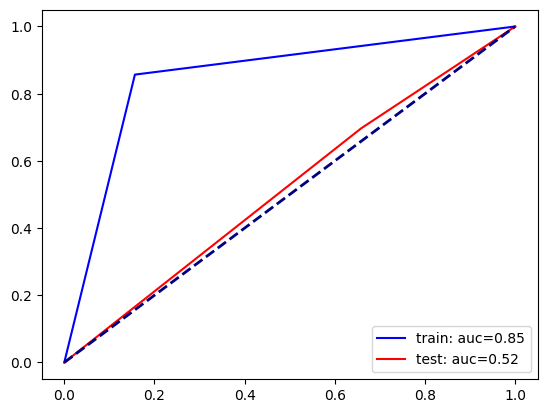

Model: XGBoost, Sampler: SMOTE_Sampler
              precision    recall  f1-score   support

           0       0.33      0.45      0.38      2189
           1       0.69      0.58      0.63      4695

    accuracy                           0.54      6884
   macro avg       0.51      0.51      0.51      6884
weighted avg       0.58      0.54      0.55      6884


Confusion Matrix: 



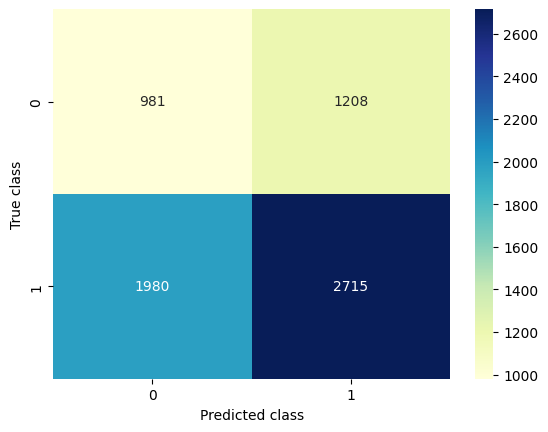

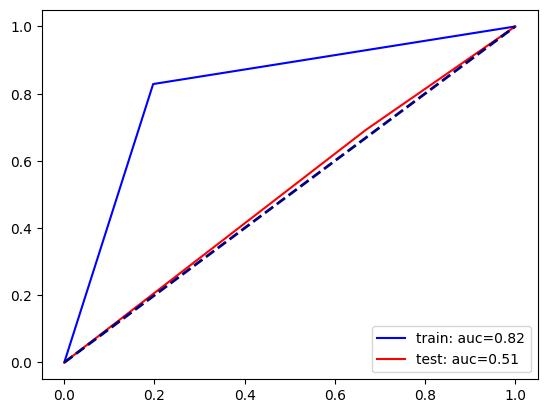


 =========Print performance summary========= 

                  Model        Sampler  Precision    Recall  F1 Score
0   Logistic Regression     no_sampler   0.682016  1.000000  0.810951
1   Logistic Regression  Under_Sampler   0.719778  0.661981  0.689670
2   Logistic Regression   Over_Sampler   0.718456  0.634292  0.673756
3   Logistic Regression  SMOTE_Sampler   0.710919  0.507561  0.592270
4         Random Forest     no_sampler   0.696748  0.812354  0.750123
5         Random Forest  Under_Sampler   0.698817  0.490735  0.576577
6         Random Forest   Over_Sampler   0.694130  0.717785  0.705759
7         Random Forest  SMOTE_Sampler   0.697669  0.637487  0.666221
8            KNeighbors     no_sampler   0.688822  0.825559  0.751017
9            KNeighbors  Under_Sampler   0.703503  0.526092  0.601999
10           KNeighbors   Over_Sampler   0.689816  0.566986  0.622399
11           KNeighbors  SMOTE_Sampler   0.685123  0.564004  0.618692
12              XGBoost     no_sampler   0

In [45]:
# Specify the models you want to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'KNeighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier()
}
evaluator = ModelEvaluatorNoon(models,X_train, X_test, y_train, y_test)
results_noon = evaluator.fit_evaluate_noon()
print('\n =========Print performance summary========= \n')
print(results_noon)